In [1]:
# Basic Imports
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

In [67]:
# Data imports
cohort = 'ADNI1'
clinical_scale = 'ADAS13'
exp_name = '{}_{}'.format(cohort,clinical_scale)

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
HC_L_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_ADNI1_left.pkl'
HC_R_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_ADNI1_right.pkl'
CT_data_path = baseline_dir + 'CT/civet_out/ADNI1_subject_ROI_CT_dict_AAL.pkl'
sub_CS_data_path = '/projects/nikhil/ADNI_prediction/input_datasets/ADNI1_BL_PTID_ADAS13_dict.pkl'
sub_DX_data_path = '/projects/nikhil/ADNI_prediction/input_datasets/ADNI1_BL_PTID_DX_bl_dict.pkl'

In [64]:
#Fused labels and volumes
sub_HC_L_dict = pickle.load( open(HC_L_data_path, "rb" ) )
sub_HC_R_dict = pickle.load( open(HC_R_data_path, "rb" ) )

HC_L_total_vol_dict = {}
HC_R_total_vol_dict = {}
for key in sub_HC_L_dict.keys():
    fused_vol = stats.mode(sub_HC_L_dict[key],axis=0)[0] #Left HC
    HC_L_total_vol_dict[key] = np.sum(fused_vol)
    fused_vol = stats.mode(sub_HC_R_dict[key],axis=0)[0] #Right HC
    HC_R_total_vol_dict[key] = np.sum(fused_vol)
    
#Mean CT values for AAL
sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
unique_ROIs = sub_CT_dict['137_S_0459'][0].keys()
CT_mean_dict = {}
for key in sub_CT_dict.keys():
    CT_roi_dict = sub_CT_dict[key][0]
    mean_CT_list = []
    for roi in unique_ROIs:
        mean_CT_list.append(np.mean(CT_roi_dict[roi]))
                
    CT_mean_dict[key] = mean_CT_list
    
print 'HC_L_keys: {}, HC_R_keys: {}, CT_keys: {}'.format(len(HC_L_total_vol_dict), len(HC_R_total_vol_dict), len(CT_mean_dict))

HC_L_keys: 698, HC_R_keys: 698, CT_keys: 806


In [84]:
# ADAS score dict
sub_CS_dict = pickle.load( open(sub_CS_data_path, "rb" ) )
sub_CS_dict_clean = filter(lambda k: not isnan(sub_CS_dict[k]), sub_CS_dict) #remove NaNs
sub_CS_dict_clean = {k: sub_CS_dict[k] for k in sub_CS_dict if not isnan(sub_CS_dict[k])}

#Dx score dict (for stratified k-fold)
sub_DX_dict = pickle.load( open(sub_DX_data_path, "rb" ) )
#sub_DX_dict_clean = filter(lambda k: not isnan(sub_DX_dict[k]), sub_DX_dict) #remove NaNs
#sub_DX_dict_clean = {k: sub_DX_dict[k] for k in sub_DX_dict if not isnan(sub_DX_dict[k])}

common_keys = set(HC_L_total_vol_dict.keys()) & set(CT_mean_dict.keys()) & set(sub_CS_dict_clean.keys())
print '# of common keys across modalities: {}'.format(len(common_keys))
X = []
y = []
y_dx = [] #Used for creating balanced k-folds
for key in common_keys:
    X.append(np.array([HC_L_total_vol_dict[key]] + [HC_R_total_vol_dict[key]] + CT_mean_dict[key]))
    y.append(sub_CS_dict_clean[key])
    y_dx.append(sub_DX_dict[key])
    
X = np.array(X)
y = np.array(y)
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)

# of common keys across modalities: 680
X shape: (680, 81), y shape: (680,)


In [101]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

#Encode Dx labels to integers map: {AD:0,CN:1,LMCI:2}
le = preprocessing.LabelEncoder()
le.fit(y_dx)
y_dx_int = le.transform(y_dx) 

stratified_KF = True
if not stratified_KF:
    print 'KFold'
    kf = KFold(len(y), n_folds=10)
else: 
    print 'Stratified KFold'
    kf = StratifiedKFold(y_dx_int, n_folds=10)
    
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx_int[test_index]==0),np.sum(y_dx_int[test_index]==1),
                                              np.sum(y_dx_int[test_index]==2)))
    print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))
    
save_experimental_setup = False  #Saves X, y, and KF
if save_experimental_setup:
    save_path = '/projects/nikhil/ADNI_prediction/input_datasets/ADNI1_CV_experimental_setup_1.pkl'
    exp_setup = {'X': X, 'y': y, 'kf':kf,'exp_name':exp_name}
    pickleIt(exp_setup, save_path)

Stratified KFold
DX distribution (AD,CN,LMCI): (15, 20, 34)
y_train_mean: 18.1325040917, y_test_mean: 17.2271014493
DX distribution (AD,CN,LMCI): (15, 20, 34)
y_train_mean: 18.1625040917, y_test_mean: 16.9614492754
DX distribution (AD,CN,LMCI): (15, 20, 34)
y_train_mean: 17.9039279869, y_test_mean: 19.2511594203
DX distribution (AD,CN,LMCI): (15, 20, 34)
y_train_mean: 18.0299181669, y_test_mean: 18.1355072464
DX distribution (AD,CN,LMCI): (15, 20, 34)
y_train_mean: 17.9666939444, y_test_mean: 18.6953623188
DX distribution (AD,CN,LMCI): (15, 20, 33)
y_train_mean: 18.0125163399, y_test_mean: 18.2936764706
DX distribution (AD,CN,LMCI): (15, 20, 33)
y_train_mean: 18.112745098, y_test_mean: 17.3916176471
DX distribution (AD,CN,LMCI): (14, 20, 33)
y_train_mean: 18.0994453507, y_test_mean: 17.5025373134
DX distribution (AD,CN,LMCI): (14, 19, 33)
y_train_mean: 17.8967263844, y_test_mean: 19.3793939394
DX distribution (AD,CN,LMCI): (14, 19, 33)
y_train_mean: 18.0895439739, y_test_mean: 17.58560

<Container object of 81 artists>

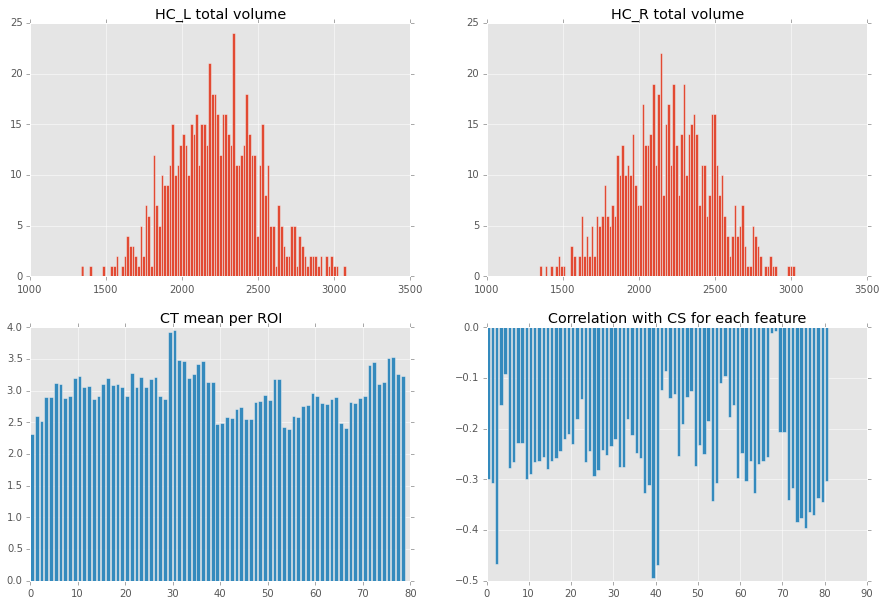

In [103]:
# QC plots
n_feat = X.shape[1]
feat_corr  = []
for col in np.arange(n_feat):
    feat_corr.append(stats.pearsonr(X[:,col],y)[0])
    
plt.figure()
plt.subplot(2,2,1)
plt.title('HC_L total volume')
plt.hist(X[:,0],bins=100)
plt.subplot(2,2,2)
plt.title('HC_R total volume')
plt.hist(X[:,1],bins=100)
plt.subplot(2,2,3)
plt.title('CT mean per ROI')
plt.bar(np.arange(n_feat-2),np.mean(X[:,2:],axis=0))
plt.subplot(2,2,4)
plt.title('Correlation with CS for each feature')
plt.bar(np.arange(n_feat),feat_corr)

In [107]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold

In [108]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'SVR', 'RFR']
model_choice_id = 0
model_choice = model_list[model_choice_id]

if model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.2, 0.1, 0.05, 0.01]} 
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True    
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
           
elif model_choice == 'RFR':
    model_clf = RandomForestRegressor(n_jobs=6)
    hyper_params = {'n_estimators':[10,50,100,200,500],'min_samples_split':[2,4,8]}
    #hyper_params = {'min_samples_split':[2,4,8,16]}
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True   
    
else:
    print "Unknown model choice"

In [ ]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load save experimental setup
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/ADNI1_CV_experimental_setup_1.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

if scale_data:
    X = preprocessing.scale(exp_setup['X'])
else:
    X = exp_setup['X']
    
y = exp_setup['X']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

#Some paths to store models and performance stats
CV_model_dir = '/projects/nikhil/ADNI_prediction/models/CV_pkls/'
save_model_path = CV_model_dir + exp_name + '_' + model_choice
load_model_path = CV_model_dir + saved_model_name

# train a new classifer? Or load a single pretrained classifier based on most frequent hyperparams found previously?
# This will NOT load K different classifiers each for outer-CV fold  
train_clf = True
save_model = False #do you really want to save all classifiers per each fold? (default false) 

if train_clf:
    # Create list of all the fold-subsets (needed for parallelization)
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []    
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    CV_r_train=[] #pearson r score for each outer fold on train set
    CV_r_valid=[] #pearson r score for each outer fold on validation set

    CV_R2_train=[] #R2 score for each outer fold on train set
    CV_R2_valid=[] #R2 score for each outer fold on validation set

    CV_MSE_train=[] #MSE for each outer fold on train set
    CV_MSE_valid=[] #MSE for each outer fold on validation set
    
    predicted_CV_scores = []
    actual_CV_scores = []
    
    # Parallization configs for ipython notebook cluster    
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  save_model=save_model, save_model_path=save_model_path)
    parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    
    
    hp_dict = collections.defaultdict(list)
    for pr in parallel_result:
        CV_r_train.append(pr['r_train'])
        CV_r_valid.append(pr['r_valid'])
        CV_R2_train.append(pr['R2_train'])
        CV_R2_valid.append(pr['R2_valid'])
        CV_MSE_train.append(pr['MSE_train'])
        CV_MSE_valid.append(pr['MSE_valid'])
        predicted_CV_scores.append(pr['predicted_fold_score'])
        actual_CV_scores.append(pr['actual_fold_scores'])
        
        for hp in hyper_params:
            hp_dict[hp].append(pr['hp_dict'][hp])
            
    #Find out most frequent hyper-params during cross-val    
    hp_mode = {}
    for hp in hyper_params:
        hp_mode[hp] = mode(hp_dict[hp])[0][0]

    print 'most frequent hp:' + str(hp_mode)
    
else: 
    #Grabs the best classifer as a result of N-fold nested CV along with the MSE and R2 stats of the outerloop
    print "Loading previously saved model: "
    f = open(load_model_path)
    result = pickle.load(f)
    test_clf = result['best_clf']
    CV_r_valid = result['CV_r']
    CV_R2_valid = result['CV_R2']
    CV_MSE_valid = result['CV_MSE']
    f.close()

print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))

In [ ]:
# Compute single model from the most frequent hyper-params (for across dataset testing)

#test_clf = Lasso(alpha=0.2)    
#test_clf = SVR(kernel='rbf',C=10)
#test_clf = RandomForestRegressor(n_estimators=200,min_samples_split=4,n_jobs=4)

save_CV_perf = True    
if save_model:
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                 'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    pickleIt(classifier_model_and_stats,save_model_path)


In [ ]:
# Plotting stuff...


In [104]:
# Some Defs
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting Inner computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'hp_dict':hp_dict, 
            'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf